In [1]:
#July 28
"""
Adding in a star-forming fraction to account for the difference of sf vs quiescent galaxies
"""

import ares
import numpy as np
import matplotlib.pyplot as pl

In [168]:
pop_halo = ares.populations.HaloPopulation()
data = ares.analysis.GalaxyPopulation() #for lit values

#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 2.0 #0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)


# OutputArr_47873077.txt averages
beta_0, beta_1, N_0, nu, gamma_0, gamma_1, logM_0, mu = [0.8873238682124077, -0.03555562381943656, 0.010417143384991343, 0.2796315756493593, \
 0.5625588540287767, 0.178661444680813, 11.748076293655107, 1.8525755484303332]

### Putting it into ARES

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


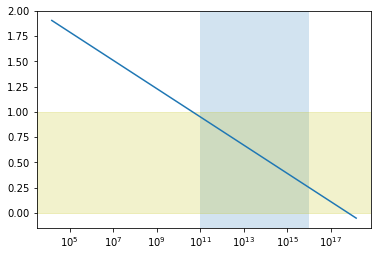

In [3]:
base_pars = ares.util.ParameterBundle('emma:model1')
pop = ares.populations.GalaxyPopulation(**base_pars)

base_pars.update(pop_sf_type='sf')
pop_sf = ares.populations.GalaxyPopulation(**base_pars)

base_pars.update(pop_sf_type='q')
pop_q = ares.populations.GalaxyPopulation(**base_pars)

fract = pop_sf._SF_fraction_PQ()

# print(fract(x=pop_halo.halos.tab_M))

pl.semilogx(pop_halo.halos.tab_M, fract(Mh=pop_halo.halos.tab_M))
pl.axvspan(10**11, 10**16, alpha=0.2)
pl.axhspan(0, 1, alpha=0.2, color="y")

pl.show()

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\analysis\GalaxyPopulation.py:1259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


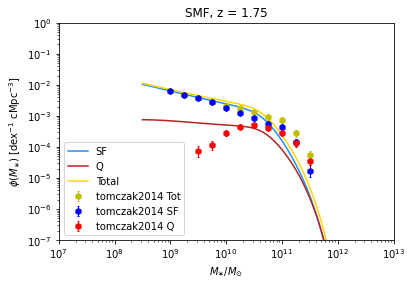

In [4]:
Sm = np.linspace(8.5, 12.1, num=100)
z = 1.75

smf_sf = pop_sf.StellarMassFunction(z, Sm)
pl.loglog(10**Sm, smf_sf, label='SF', color="dodgerblue")

smf_q = pop_q.StellarMassFunction(z, Sm)
pl.loglog(10**Sm, smf_q, label='Q', color="firebrick")

smf = pop.StellarMassFunction(z, Sm)
pl.loglog(10**Sm, smf, label='Total', color="gold")

data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 Tot", quantity="smf_tot")
data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 SF", color="b", ecolor='b',  mec='b')
data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 Q", quantity="smf_q")

pl.title("SMF, z = {}".format(z))
pl.legend()
pl.show()

#### Quenched vs SF
For given mass, what is chance it is quenched?  
Parametrize # objects that are quenched wrt (mass, z)

$SF_{fract} = m \cdot log10(halo~mass) + b$   
Then get the galaxy density we have:   
    Star-forming: $Dn/dm \cdot SF_{fract} $   
    Quiescent: $Dn/dm \cdot (1-SF_{fract}) $  

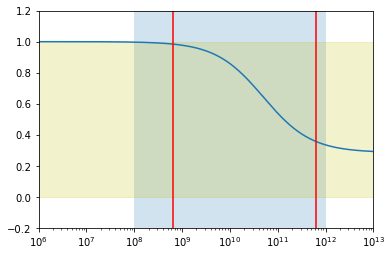

In [210]:
#it's a fraction so [0, 1] - how to make sure this happens? cause mass is going to be a big value
#also which way should it go? --> higher HM =  lower sf fraction

sf_frac = lambda c, b, mass: c*mass + b

def fract(c, b):
    
#     f = -c*np.log10(pop_halo.halos.tab_M) + b
    #should it be logged?
   
    f = fract_points(11, 16)
    
    return f

alpha = 0.9
# alpha**(

z = 1

def fract_points(minM, maxM):
    perMin = 0.95
    perMax = 0.25
    
    m = (perMax - perMin) / (maxM - minM)
    f =  m*(np.log10(pop_halo.halos.tab_M) - maxM) + perMax   
    
#     return f
#     return -alpha**f + 1
#     return f**alpha
#     return tanh3_m(pop.SMHM(z, 0), -0.3, -10.7, -.3)

    return tanh_m(pop.SMHM(z, 0), -2.8, -10.7, 2.8, 1.8)
# tanh2_m
# -0.68049461, -9.68705742

#a funct of z, more negative with higher z

#HM
# pl.semilogx(pop_halo.halos.tab_M, fract(0.05, 1))
# pl.semilogx(pop_halo.halos.tab_M, fract_points(11, 16))
# pl.axvspan(10**11, 10**16, alpha=0.2)
# pl.axhspan(0, 1, alpha=0.2, color="y")

# pl.show()

#SM
z = 0
minM = 11
maxM = 14.5

pl.axvspan(10**8, 10**12, alpha=0.2)
pl.semilogx(pop.SMHM(z, 0), fract_points(minM, maxM))

pl.axhspan(0, 1, alpha=0.2, color="y")

pl.axvline(pop.SMHM(z, minM), ymin=0, ymax=1, color="r")
pl.axvline(pop.SMHM(z, maxM), ymin=0, ymax=1, color="r")

pl.xlim(1e6, 1e13)
pl.ylim(-0.2, 1.2)


pl.show()

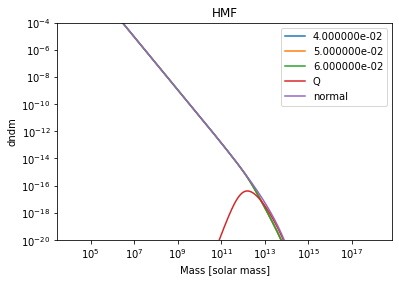

In [207]:
z = 2

# for c in [1e-18, 1e-19, 1e-20]:
for c in [0.04, 0.05, 0.06]:

    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*fract(c, 1), label='%e' %c)

pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :]*(1-fract(1, 1)), label='Q')
    
pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :], label='normal')
pl.legend()
pl.ylabel('dndm')
pl.xlabel('Mass [solar mass]')
pl.title('HMF')

pl.ylim(1e-20, 1e-4)
pl.show()

In [10]:
# derivative of m(M) wrt M
def dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    n2 = (-beta)*(pop_halo.halos.tab_M**(-beta-1)/M_1**(-beta)) + gamma*(pop_halo.halos.tab_M**(gamma-1)/M_1**(gamma))
    
    dydx = mM_ratio - pop_halo.halos.tab_M * 2 * N * n2 * ( (pop_halo.halos.tab_M/M_1)**(-beta) + \
                                                            (pop_halo.halos.tab_M/M_1)**(gamma) )**(-2) 

    return dydx

#derivative of log10( m ) wrt M
def dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    
    dydx = -1* ((gamma-1)*(pop_halo.halos.tab_M/M_1)**(gamma+beta) - beta - 1) / (np.log(10)*pop_halo.halos.tab_M*((pop_halo.halos.tab_M/M_1)**(gamma+beta) + 1))

    return dydx

In [156]:
#double power law
c = 0.05
b = 1

def SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='sf'):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10( 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2
    
    """
    tab_dndm (halo) -> dndlog(m) (SM)
    need: tab_dndm / d(log(ratio)/dM
    """
    
    if sf == 'sf': #star-forming 
        SMF = pop_halo.halos.tab_dndm[k, :]*fract(c, b) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
    elif sf == 'q': # quiescent
        SMF = pop_halo.halos.tab_dndm[k, :]*(1-fract(c, b)) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
    else: # total
        SMF = pop_halo.halos.tab_dndm[k, :] / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM

    
    return SMF,  mM_ratio

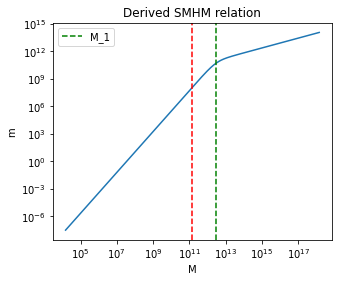

In [129]:
z = 1

N = N_0 * (z + 1)**nu
M_1 = 10**(logM_0)*(z+1)**mu
beta = beta_1*z+beta_0
gamma = gamma_0*(z + 1)**gamma_1

SMF, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma) #* pop_halo.halos.tab_M
ratio = 10**(r)
HM = pop_halo.halos.tab_M

fig, ax = pl.subplots(1, 1, figsize=(5, 4))
pl.subplots_adjust(hspace=0)

ax.set_title("Derived SMHM relation")
ax.loglog(HM, ratio*pop_halo.halos.tab_M)#, label='c = %.e' %c)

ax.set(xlabel='M', ylabel='m')
# ax.set_ylim(1e7, 1e12)
# ax.set_xlim(1e10, 1e15)
ax.axvline(M_1, color="g", label="M_1", ls="--")

ax.legend()

# print(HM)

from scipy.interpolate import interp1d

f = interp1d(ratio*pop_halo.halos.tab_M, HM)

ax.axvline(f(10**8), color="r", label="M", ls="--")
# ax.axvline(10**pop.HM_fromSM(z, 11), color="r", label="M", ls="--")

pl.show()

# print("{:e}".format(f(10**8)))

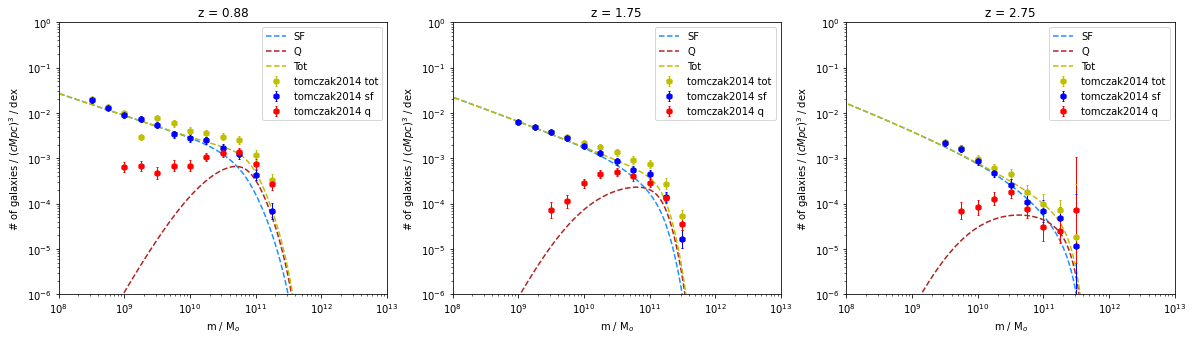

In [208]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

# [(0.35) sf only, 0.875, 1.125, 1.75, 2.25, 2.75]

for i, z in enumerate([0.875, 1.75, 2.75]):
    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0)*(z+1)**mu
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
       
    #plot lit values
    data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 tot", quantity="smf_tot", ax=axs[i])
    data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 sf", ax=axs[i], color="b", ecolor='b',  mec='b')
    data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 q", quantity="smf_q", ax=axs[i])
    
    SMF_sf, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='sf')
    SMF_q, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='q')
    SMF_tot, r = SMF_Moster2010(z, pop_halo, N, M_1, beta, gamma, sf='tot')


    #using equ 2 to get the new stellar masses
    Sm = 10**(r + np.log10(pop_halo.halos.tab_M))
    
    HM = pop_halo.halos.tab_M

    #plotting
    axs[i].loglog(Sm, SMF_sf, label='SF', ls="--", color='dodgerblue')
    axs[i].loglog(Sm, SMF_q, label='Q', ls="--", color='firebrick')
    axs[i].loglog(Sm, SMF_tot, label='Tot', ls="--", color='y')

    
#     axs[i].loglog(HM, SMF_sf, label='SF', ls="--", color='dodgerblue')
#     axs[i].loglog(HM, SMF_q, label='Q', ls="--", color='firebrick')
    
    
    axs[i].set_title("z = %.2f" %z)
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
    axs[i].set_xlim(1e8, )

    axs[i].legend()

pl.show()

In [6]:
# a = 0.1

def fract_points_z(z, minHM, maxHM):
    perMin = 0.95
    perMax = 0.25
    
#     minHM = pop.HM_fromSM(z, minSM)
#     maxHM = pop.HM_fromSM(z, maxSM)
    
    m = (perMax - perMin) / (maxHM - minHM)
    f = m*(np.log10(pop_halo.halos.tab_M) - maxHM) + perMax
    
    return f


In [7]:
# minM = 8
# maxM = 12.5

minM = 11
maxM = 16.5

def SMF_z(z, pop_halo, N, M_1, beta, gamma, sf=True):
    
    k = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    mM_ratio = np.log10( 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2
    
    if sf: #star-forming 
        SMF = pop_halo.halos.tab_dndm[k, :]*fract_points_z(z, minM, maxM) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM
    else: # quiescent
        SMF = pop_halo.halos.tab_dndm[k, :]*(1-fract_points_z(z, minM, maxM)) / dlogm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio) #dn/dM / d(log10(m))/dM

    return SMF,  mM_ratio

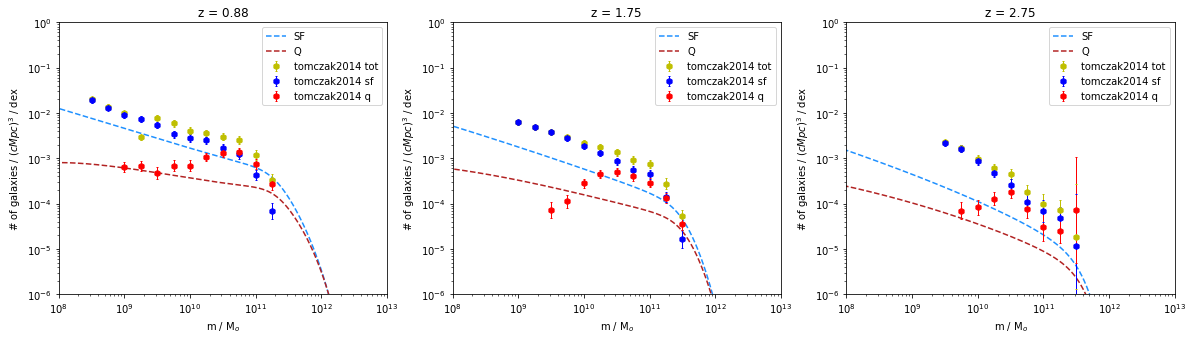

In [13]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

# [(0.35) sf only, 0.875, 1.125, 1.75, 2.25, 2.75]

for i, z in enumerate([0.875, 1.75, 2.75]):
    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0)*(z+1)**mu
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
       
    #plot lit values
    data.PlotSMF(z, sources="tomczak2014", color="y", ecolor='y', mec='y', label="tomczak2014 tot", quantity="smf_tot", ax=axs[i])
    data.PlotSMF(z, sources="tomczak2014",  label="tomczak2014 sf", ax=axs[i], color="b", ecolor='b',  mec='b')
    data.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r',  mec='r', label="tomczak2014 q", quantity="smf_q", ax=axs[i])
    
    SMF_sf, r = SMF_z(z, pop_halo, N, M_1, beta, gamma)
    
    SMF_q, r = SMF_z(z, pop_halo, N, M_1, beta, gamma, sf=False)

    #using equ 2 to get the new stellar masses
    Sm = 10**(r + np.log10(pop_halo.halos.tab_M))

    #plotting
    axs[i].loglog(Sm, SMF_sf, label='SF', ls="--", color='dodgerblue')
    axs[i].loglog(Sm, SMF_q, label='Q', ls="--", color='firebrick')
    
    axs[i].set_title("z = %.2f" %z)
    axs[i].set(xlabel='m / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-6, 1e0)
    axs[i].set_xlim(1e8, )

    axs[i].legend()

pl.show()

In [15]:
from scipy.optimize import curve_fit
# scipy.optimize.curve_fit

def getData(z):
    dataTot = data.compile_data(z, sources="tomczak2014", round_z=False, quantity='smf_tot')['tomczak2014']
    dataSf = data.compile_data(z, sources="tomczak2014", round_z=False, quantity='smf_sf')['tomczak2014']
    dataQ = data.compile_data(z, sources="tomczak2014", round_z=False, quantity='smf_q')['tomczak2014']

    return dataTot, dataSf, dataQ
# print(dataQ['err'][0])

In [86]:
def fract_points(minM, maxM):
    perMin = 1.00
    perMax = 0.35
    
    m = (perMax - perMin) / (maxM - minM)
    f =  m*(np.log10(pop_halo.halos.tab_M) - maxM) + perMax    
#     return -alpha**f + 1
#     return f**alpha
    return np.tanh(f)/2 + 0.5

def fit_fract_points(sm, minM, maxM, perMin, perMax):
#     perMin = 1.00
#     perMax = 0.35
    
    HM = pop.HM_fromSM(1.75, sm)
    
    m = (perMax - perMin) / (maxM - minM)
#     f =  m*(np.log10(pop_halo.halos.tab_M) - maxM) + perMax 
    f =  m*(HM - maxM) + perMax    

#     return -alpha**f + 1
#     return f**alpha
    return np.tanh(f)/2 + 0.5


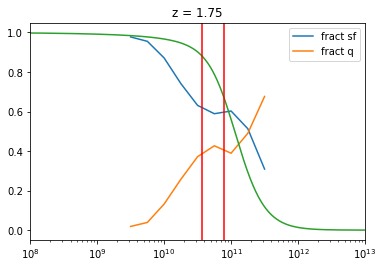

In [87]:
z = 1.75
minM = 12.4
maxM = 12.9

dataTot, dataSf, dataQ = getData(z)

fract_sf = dataSf['phi'][2:]/dataTot['phi'][2:]
fract_q = dataQ['phi']/dataTot['phi'][2:]

pl.semilogx(dataSf['M'][2:], fract_sf, label="fract sf")
pl.semilogx(dataSf['M'][2:], fract_q, label="fract q")

pl.semilogx(pop.SMHM(z, 0), fract_points(minM, maxM))
pl.axvline(pop.SMHM(z, minM), ymin=0, ymax=1, color="r")
pl.axvline(pop.SMHM(z, maxM), ymin=0, ymax=1, color="r")

pl.xlim(1e8 , 1e13)
pl.title("z = 1.75")
pl.legend()
pl.show()

In [189]:
qui = lambda m, a, b, c, d, e, f: a*m**5 + b*m**4 + c*m**3 + d*m**2 + e*m + f
tri = lambda m, a, b, c, d: a*m**3 + b*m**2 + m*c + d
lin = lambda m, a, b: m*a + b

def tanh_m(m, a, b, c, d):   
#     return (np.tanh(a*(np.log10(m) + b)) + 1)/2
    return (np.tanh(a*(np.log10(m) + b)) + d)/c


def tanh2_m(m, a, b):   
    return (np.tanh(a*(np.log10(m) + b)**3)+1)/2

def tanh3_m(m, a, b, c):
    return (np.tanh(a*(np.log10(m) + b)**3 + c*(np.log10(m) + b))+1)/2


def qui_m(m, a, b):   
    return a*m**5 + b*m**3 + m*c + d

# popt, pcov = curve_fit(tanh2_m, dataSf['M'][2:], fract_sf)#, p0=[12.4, 13.5, 1, 0.35], sigma=dataSf['err'][0][2:])

# popt, pcov = curve_fit(fit_fract_points, dataSf['M'][2:], fract_sf, p0=[12.4, 13, 1.0, 0.35])
#, sigma=dataSf['err'][0][2:])#, bounds=( [8, 9, 0, 0], [14, 16 , 1, 1]) )

# popt, pcov = np.polyfit(dataSf['M'][2:], fract_sf, 3, cov=True)
# popt, pcov = np.polyfit(dataSf['M'][2:], fract_sf, 5, cov=True)

print(popt)

[1. 1.]


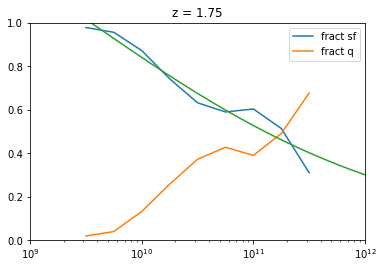

In [103]:
z = 1.75
minM = 12.4
maxM = 12.9

dataTot, dataSf, dataQ = getData(z)

fract_sf = dataSf['phi'][2:]/dataTot['phi'][2:]
fract_q = dataQ['phi']/dataTot['phi'][2:]

pl.semilogx(dataSf['M'][2:], fract_sf, label="fract sf")
pl.semilogx(dataSf['M'][2:], fract_q, label="fract q")


# pl.semilogx(pop.SMHM(z, 0), qui(pop.SMHM(z, 0), popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]))

# pl.semilogx(pop.SMHM(z, 0), tri(pop.SMHM(z, 0), popt[0], popt[1], popt[2], popt[3]))
# pl.semilogx(pop.SMHM(z, 0), lin(pop.SMHM(z, 0), popt[0], popt[1]))

pl.semilogx(pop.SMHM(z, 0), tanh_m(pop.SMHM(z, 0), popt[0], popt[1]))
# pl.semilogx(pop.SMHM(z, 0), tanh2_m(pop.SMHM(z, 0), popt[0], popt[1], popt[2]))
# pl.semilogx(pop.SMHM(z, 0), tanh3_m(pop.SMHM(z, 0), popt[0], popt[1], popt[2]))


pl.xlim(1e9 , 1e12)
pl.ylim(0, 1)
pl.title("z = 1.75")
pl.legend()
pl.show()

In [56]:
zArr = [0.875, 1.125, 1.75, 2.25, 2.75]
x = [2, 1, 2, 2, 1]

fits = []

for i, z in enumerate(zArr):
#     print(z)

    dataTot, dataSf, dataQ = getData(z)

    fract_sf = dataSf['phi'][x[i]:]/dataTot['phi'][x[i]:]
    fract_q = dataQ['phi']/dataTot['phi'][x[i]:]
    try:
        popt, pcov = curve_fit(tanh_m, dataSf['M'][x[i]:], fract_sf)#, p0=[12.4, 13.5, 1, 0.35], sigma=dataSf['err'][0][2:])

        perr = np.sqrt(np.diag(pcov))
    
        fits.append([popt, perr])
    except:
        print("failed to fit: {}".format(z))
        fits.append([[0, 0], [0, 0]])
    


failed to fit: 2.25


C:\Users\Emma\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


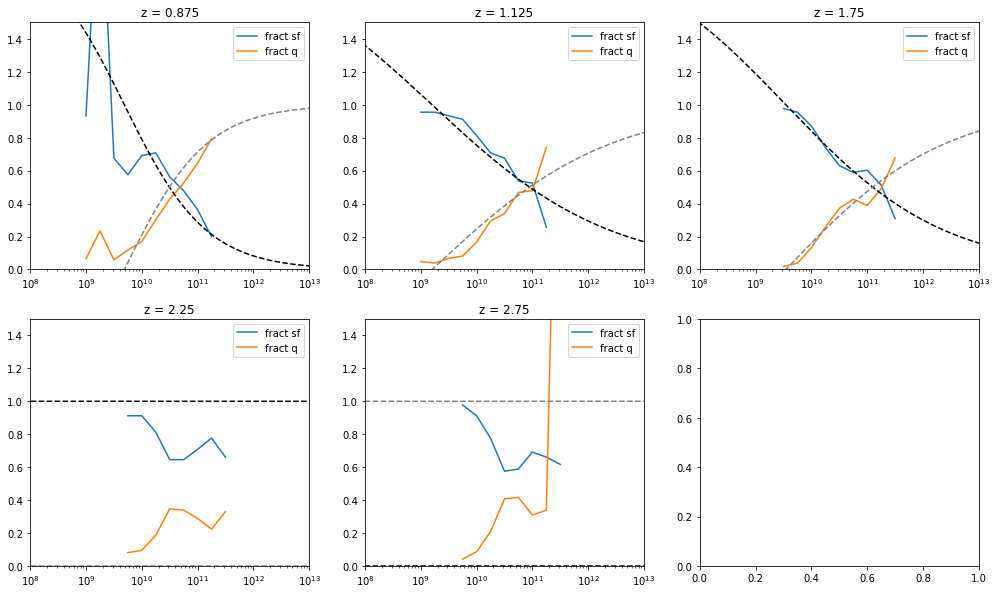

In [57]:

fig, axs = pl.subplots(2, 3, figsize=(17, 10))
ax = axs.flat

for i, z in enumerate(zArr):

    dataTot, dataSf, dataQ = getData(z)

    fract_sf = dataSf['phi'][x[i]:]/dataTot['phi'][x[i]:]
    fract_q = dataQ['phi']/dataTot['phi'][x[i]:]

    ax[i].semilogx(dataSf['M'][x[i]:], fract_sf, label="fract sf")
    ax[i].semilogx(dataSf['M'][x[i]:], fract_q, label="fract q")
#     pl.yscale('log')

    ax[i].semilogx(pop.SMHM(z, 0), tanh_m(pop.SMHM(z, 0), fits[i][0][0], fits[i][0][1]), ls="--", color="black")
    ax[i].semilogx(pop.SMHM(z, 0), 1-tanh_m(pop.SMHM(z, 0), fits[i][0][0], fits[i][0][1]), ls="--", color="grey")

    ax[i].set_title("z = {}".format(z))
    ax[i].legend()
    ax[i].set_ylim(0, 1.5)
    ax[i].set_xlim(1e8, 1e13)

# pl.title("z = %.2f" %z)
pl.show()

[-0.68049461 -9.68705742]
[-0.31403827 -9.20102371]
[-0.35281719 -9.54106948]


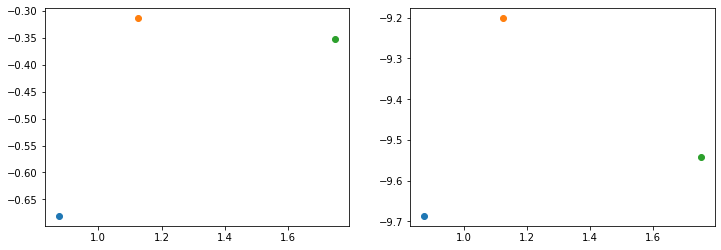

In [55]:
# print(fits)

fig, ax = pl.subplots(1, 2, figsize=(12, 4))

# for i, z in enumerate(zArr):
for i, z in enumerate([0.875, 1.125, 1.75]):

    print(fits[i][0])
    ax[0].scatter(z, fits[i][0][0])
    
    ax[1].scatter(z, fits[i][0][1])

    
pl.show()

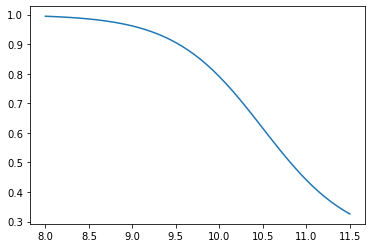

In [187]:
def tanh_x(m, a, b, c, d):   
#     return (np.tanh(a*(np.log10(m) + b)) + 1)/2
    return (np.tanh(a*(m + b)) + d)/c

x = np.linspace(8, 11.5, 50)

pl.plot(x, tanh_x(x, -0.98049461, -10.5, 2.6, 1.6))
pl.show()
    